In [1]:
# %load_ext autoreload
# %autoreload 2

from IPython.lib.deepreload import reload as dreload
import os
import sys

import numpy as np
import torch
import torch.optim as optim
import torch.utils.data as dt

from skimage import io, measure
import matplotlib.pyplot as plt

from tifffile import imread, imsave
from stackview import orthogonal as imshow
import warnings

warnings.filterwarnings("ignore")

import time
from glob import glob
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    LearningRateMonitor,
    ModelCheckpoint,
    EarlyStopping,
)

sys.path.append("../../gap/")
from GAP_3DUNET_ResBlockB import UN
from BinomDataset import BinomDataset3D
from inference import sample_image


# Training

### Loading the data
_________________

DIRPATH is the folder contianing the 3D tiff file.

In [2]:
DIRPATH = "/mnt/d/Yehe/gaptest/"
filePaths = [
    os.path.join(DIRPATH, f) for f in os.listdir(DIRPATH) if f.endswith(".tif")
]
fileNames = [os.path.splitext(os.path.basename(f))[0] for f in filePaths]

dataList = []
channelList = []

# load and frint the information of the data
print(f"{'ID':<4}{'NAME':<24}{'SHAPE':<4}")
for idx, name in enumerate(fileNames):
    data = imread(filePaths[idx])
    if len(data.shape) == 3:
        data = data[:, None, ...]
    data = data.swapaxes(0, 1)
    dataList.append(data)
    channelList.append(data.shape[0])
    print(f"{idx:<3}{name[28:]:<25}{data.shape}")

ID  NAME                    SHAPE
0   405Pwr20                (2, 504, 512, 512)
1   405Pwr50                (2, 504, 512, 512)
2   BlankA                  (2, 504, 512, 512)
3   BlankB                  (2, 504, 512, 512)
4   groundtruth             (3, 11, 512, 512)
5   LineAccu1               (3, 517, 512, 512)
6   LineAccu16              (3, 517, 512, 512)
7   LineAccu4               (3, 517, 512, 512)
8   STEDAccu16 LocationB    (1, 504, 512, 512)
9   STEDAccu16              (1, 504, 512, 512)
10  STEDBlankAccu16         (1, 504, 512, 512)


In [3]:
ID = 7
CHANNEL = 2
NAME = fileNames[ID][28:]
data = dataList[ID][CHANNEL]
imshow(data, 
       colormap="magma", 
       display_max=3,
       )

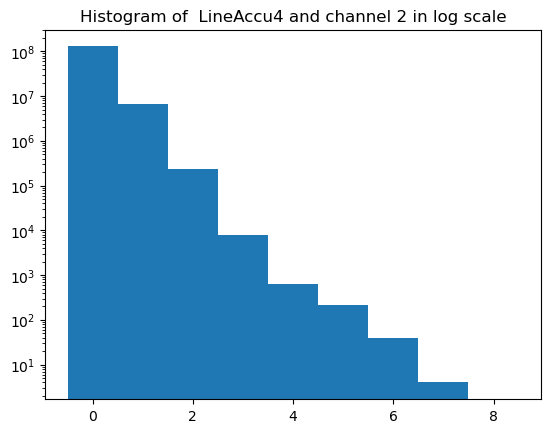

In [4]:
# plot the histogram of the data in log scale
_ = plt.hist(data.flatten(), bins=np.arange(10) - 0.5, log=True)
plt.title(f"Histogram of {NAME} and channel {CHANNEL} in log scale")
plt.show()

In [5]:
def psnrToString(inp):
    if inp < 0:
        return "m" + str(-inp)
    else:
        return str(inp)


# we set the pseudo PSNR range used for splitting the images into input and target
unitThickness = 64
windowSize = (64, 64, 64)
WINDOWSIZESTR = "x".join(map(str, windowSize))
minpsnr = -40
maxpsnr = 10
batch_size = 8

name = f"3DB_{NAME}_C{CHANNEL}_PSNR{psnrToString(minpsnr)}to{psnrToString(maxpsnr)}_WIN{WINDOWSIZESTR}"
CHECKPOINT_PATH = "./models/"

print(name)

3DB_ LineAccu4_C2_PSNRm40to10_WIN64x64x64


In [16]:
maxepochs = 30  # train longer for better results
device = torch.device("cuda:0")

# Create pytorch dataset
dataset = BinomDataset3D(
    data[: round(data.shape[0] * 0.8)],
    unitThickness=unitThickness,
    windowSize=windowSize,
    rand_crop=True,
    minPSNR=minpsnr,
    maxPSNR=maxpsnr,
    virtSize= 500*32,
    augment=False,
)

val_dataset = BinomDataset3D(
    data[: round(data.shape[0] * 0.8)],
    unitThickness=unitThickness,
    windowSize=windowSize,
    rand_crop=True,
    minPSNR=minpsnr,
    maxPSNR=maxpsnr,
    augment=False,
)

# Create pytorch dataloader for training and validation sets
train_loader = dt.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=False,
    num_workers=12,
)
val_loader = dt.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    pin_memory=False,
    num_workers=12,
)

img = next(iter(val_loader))
print(img.shape)

torch.set_float32_matmul_precision('high')
trainer = pl.Trainer(
    accelerator="gpu",
    devices= [0],
    default_root_dir=os.path.join(CHECKPOINT_PATH, name),
    gradient_clip_val=0.5,
    max_epochs=maxepochs,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
        LearningRateMonitor("epoch"),
        EarlyStopping("val_loss", patience=2000),
    ],
)

model = UN(
    levels=10, 
    channels=1, 
    depth=5, 
    start_filts=32, 
    up_mode="transpose",
    z_conv_stage=2,
).to(device)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


torch.Size([8, 2, 64, 64, 64])


In [17]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type       | Params
------------------------------------------
0 | conv_final | Conv3d     | 33    
1 | down_convs | ModuleList | 8.1 M 
2 | up_convs   | ModuleList | 3.4 M 
------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
45.802    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [8]:
trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name) + ".ckpt")

# Denoising

In [9]:
model = UN.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name) + ".ckpt").to("cpu")

In [10]:
# dataTest = imread('./data/testData.tif')[:1]     # to speed things up, we are only doing the first image
# dataTestGT =imread('./data/testDataGT.tif')[:1]
z, y, x = (190, 0, 0)
z_size = 64
dataTest1 = data[z : z + z_size, x : x + 512, y : y + 512]
# dataTest2 = data[z_size : z_size + z_size, x : x + 512, y : y + 512]
print(data.shape)

imshow(
    dataTest1, colormap="inferno"
)

(517, 512, 512)


In [15]:
dataTestB = torch.from_numpy(dataTest1).float()
out = torch.exp(model(dataTestB[None, None, ...]))
out = dataTest1.sum() * out / out.sum()
dataTest1 = out.detach().numpy()[0,0]
del out, dataTestB

# dataTestB = torch.from_numpy(dataTest2).float()
# out = torch.exp(model(dataTestB[None, None, ...]))
# out = dataTest1.sum() * out / out.sum()
# dataTest2 = out.detach().numpy()[0,0]
# del out, dataTestB

plt.imshow(
    dataTest1[16],
    cmap="inferno",
    vmin=0,
    vmax=0.4,
)

KeyboardInterrupt: 

# Sampling images

torch.Size([1, 1, 64, 64, 64])
(1, 1, 64, 64, 64)


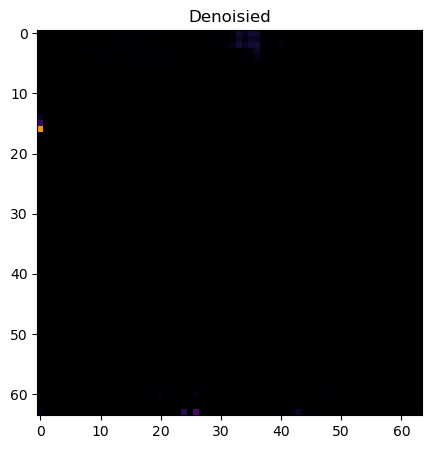

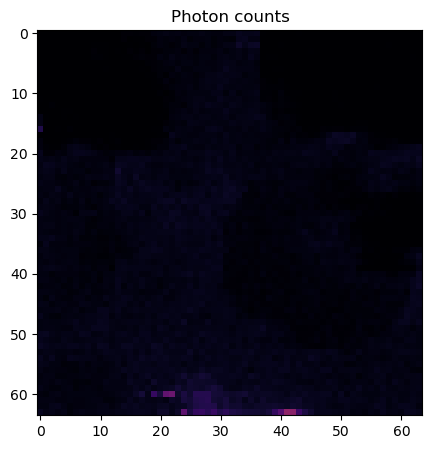

_______________________________________ 405
time (s): 96.77375555038452 time per image (s) 96.77375555038452


In [ ]:
import matplotlib.image as mpimg
import time
import numpy as np

# We are starting with an image containing zeros,
# i.e., sampling from scratch

# we just have 1 channel
channels = 1
# we can sample multiple images at the same time in a batch
batch_size = 1
# for best results this should correspond to training pach size
pixels_x = 64
pixels_y = 64

inp_img = torch.zeros(batch_size, channels, 64, pixels_y, pixels_x)
print(inp_img.shape)

for i in range(1):
    startTime = time.time()

    # sampling the image(s)
    denoised, photons, stack, iterations = sample_image(
        inp_img, 
        model, 
        beta=0.05, 
        save_every_n=10, 
        max_psnr=40,
    )

    # In case we do multiple images in a batch, we show all of them.
    for j in range(denoised.shape[0]):
        #         print(iterations)

        print(denoised.shape)
        plt.figure(figsize=(5, 5))
        plt.imshow(
            denoised[j, 0, [10]].squeeze(),
            cmap="inferno",
            vmin=0,
            vmax=np.percentile(denoised[j], 99.99),
        )
        plt.title("Denoisied")
        plt.show()

        plt.figure(figsize=(5, 5))
        plt.imshow(
            photons[j, 0, [10]].squeeze(), 
            cmap="inferno", 
            vmin=0, 
            vmax=np.percentile(photons[j], 99.99),
        )
        plt.title("Photon counts")
        plt.show()

    print("_______________________________________", iterations)

    endTime = time.time()
    elapsedTime = endTime - startTime
    print(
        "time (s):", elapsedTime, "time per image (s)", elapsedTime / denoised.shape[0]
    )

## Looking at the intermediate outputs

0.3468027


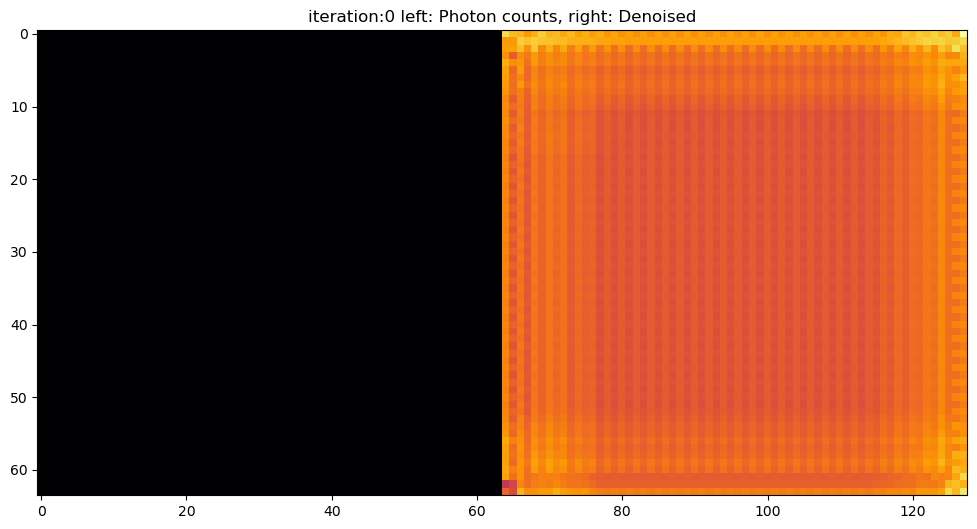

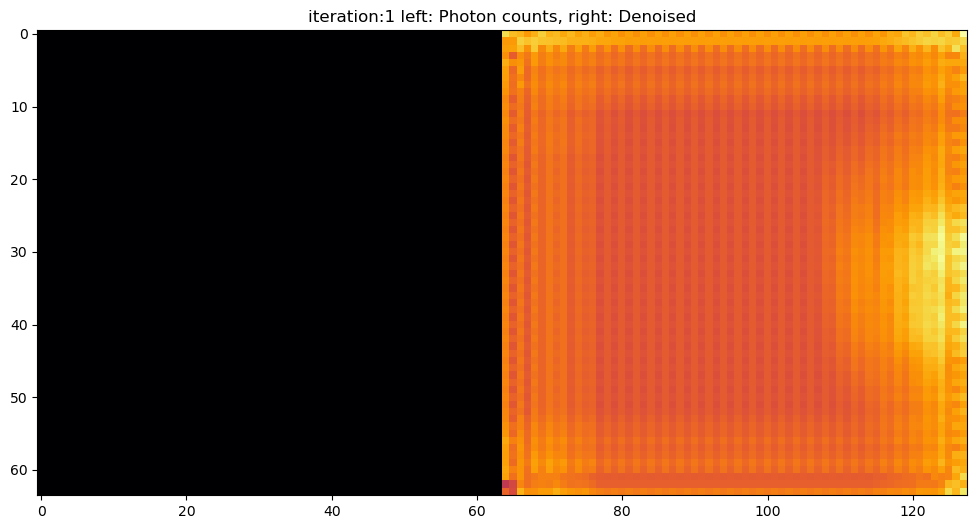

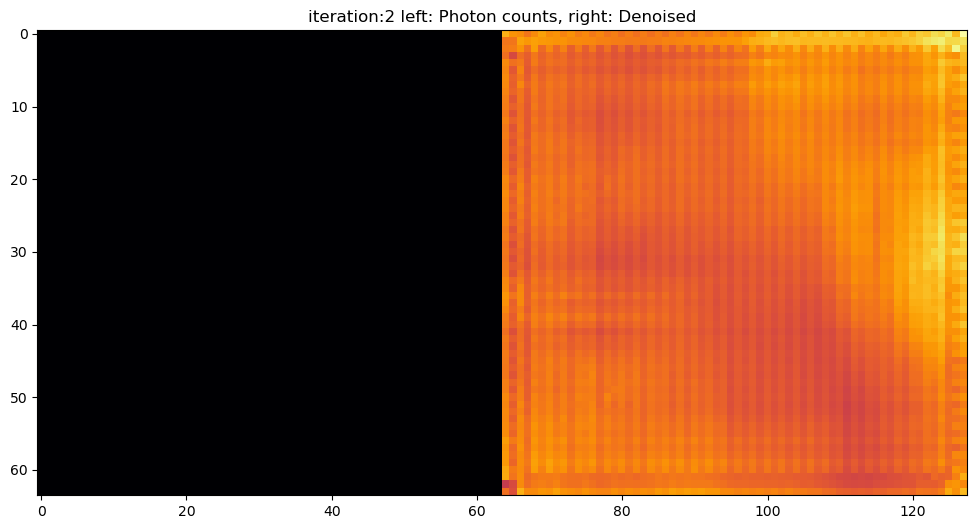

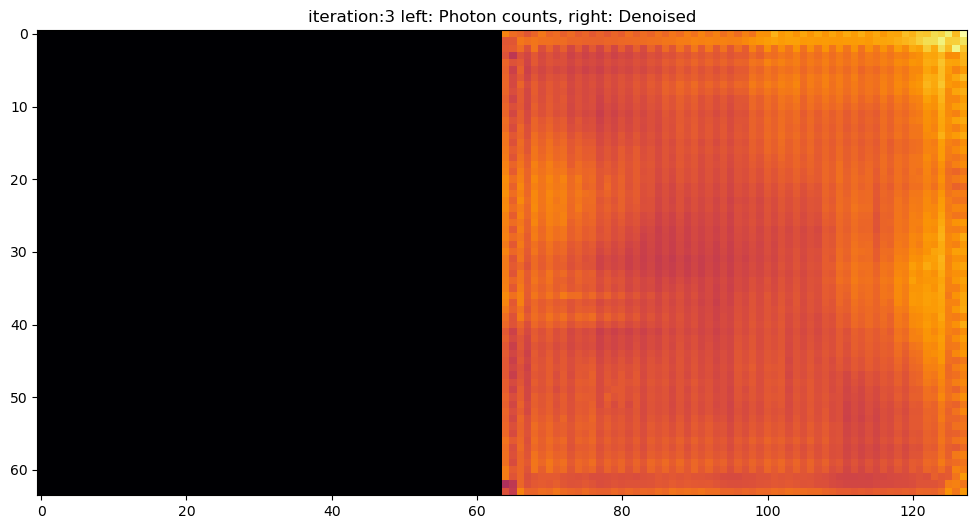

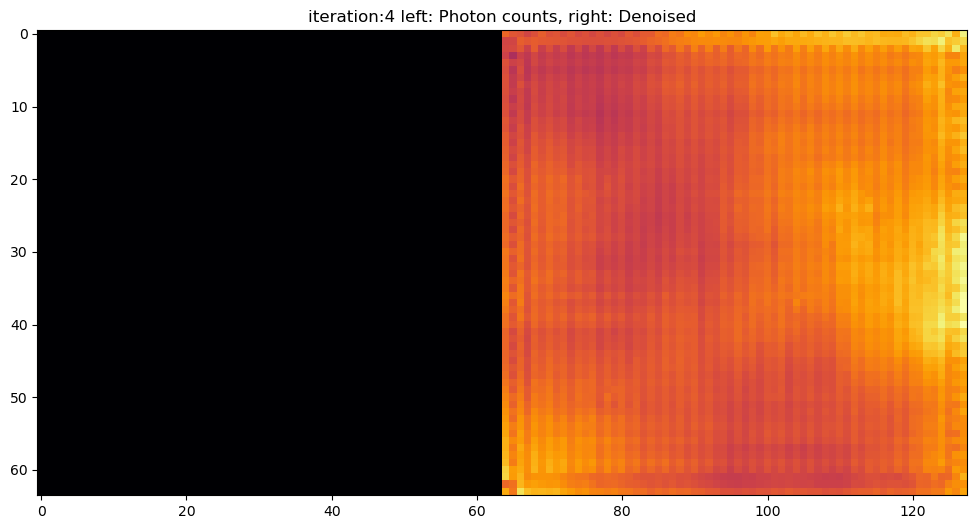

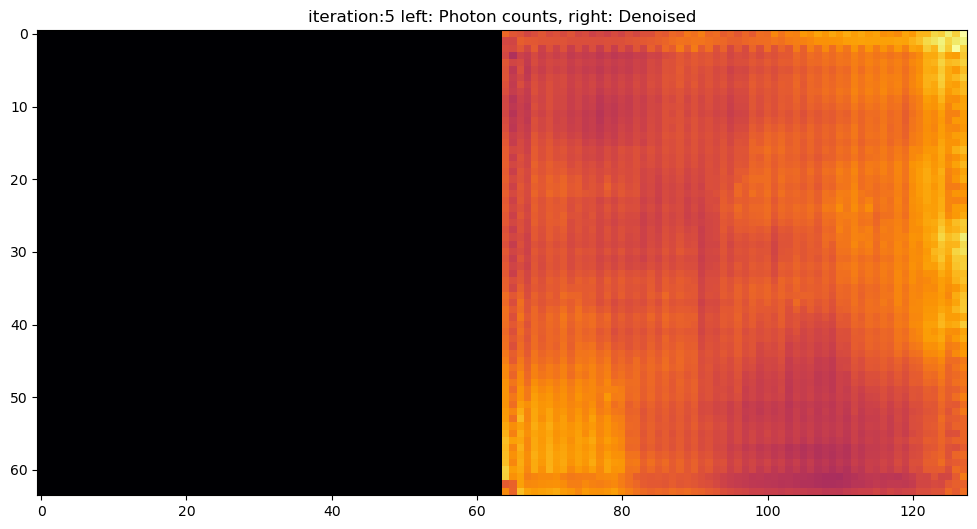

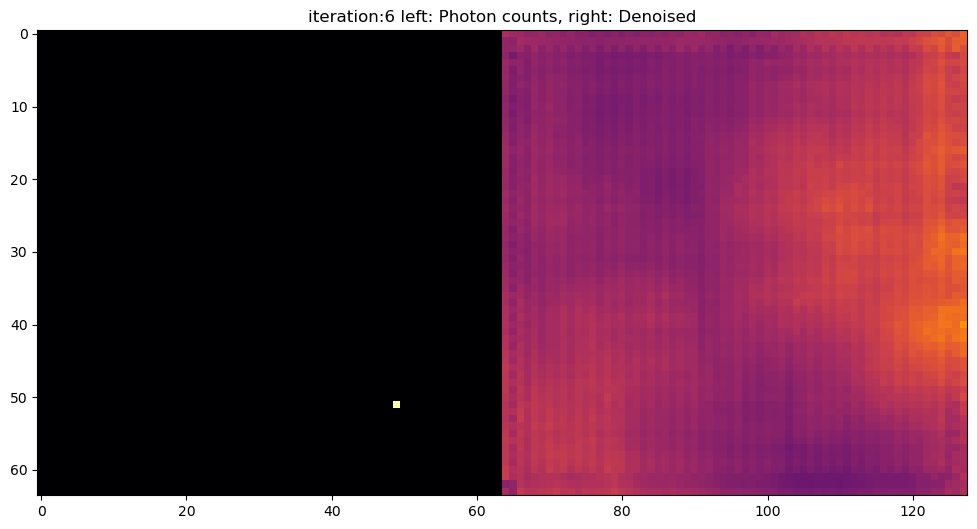

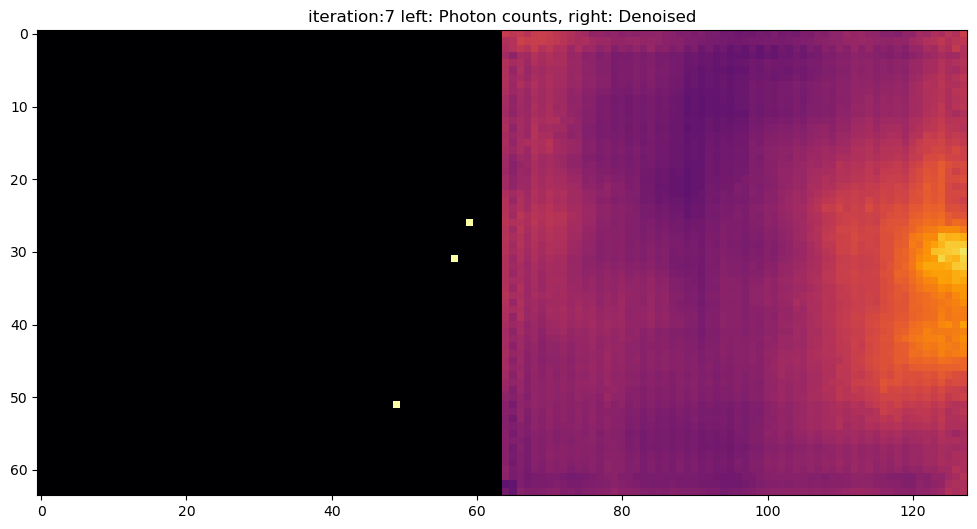

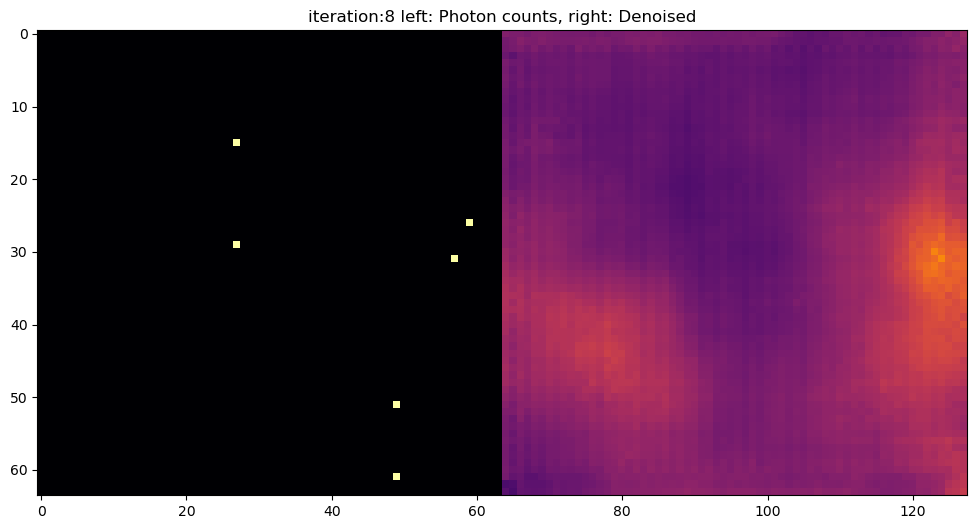

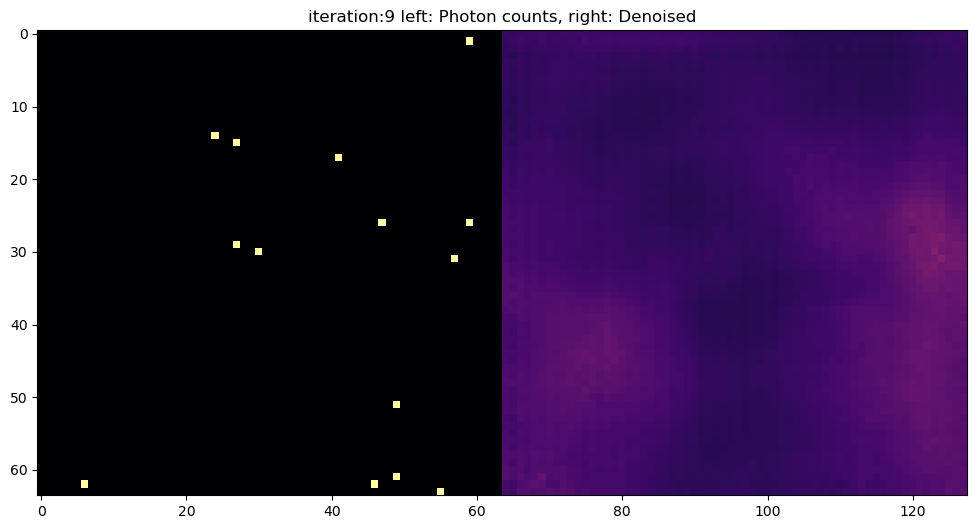

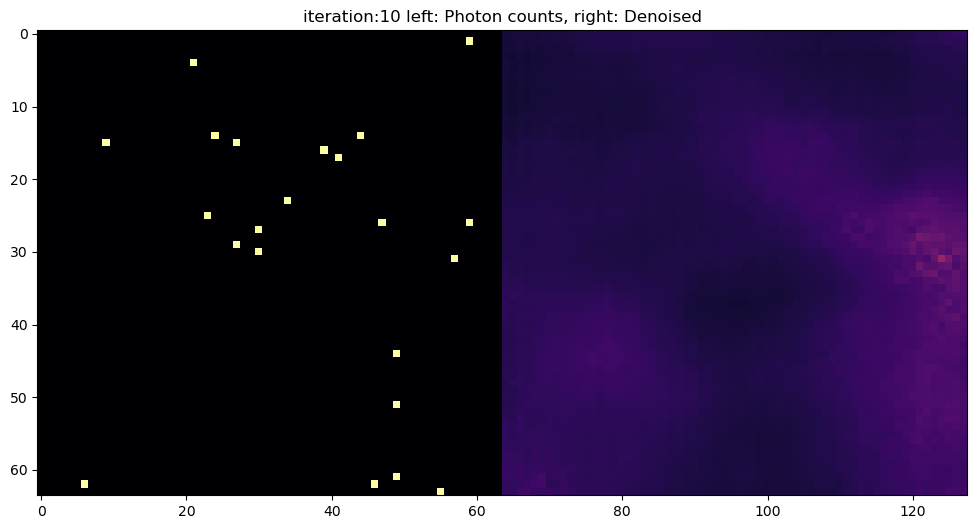

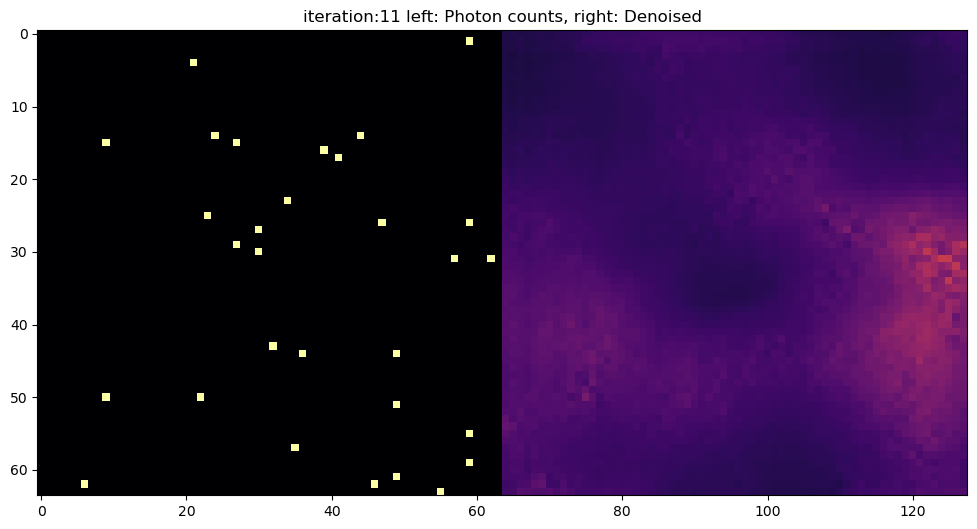

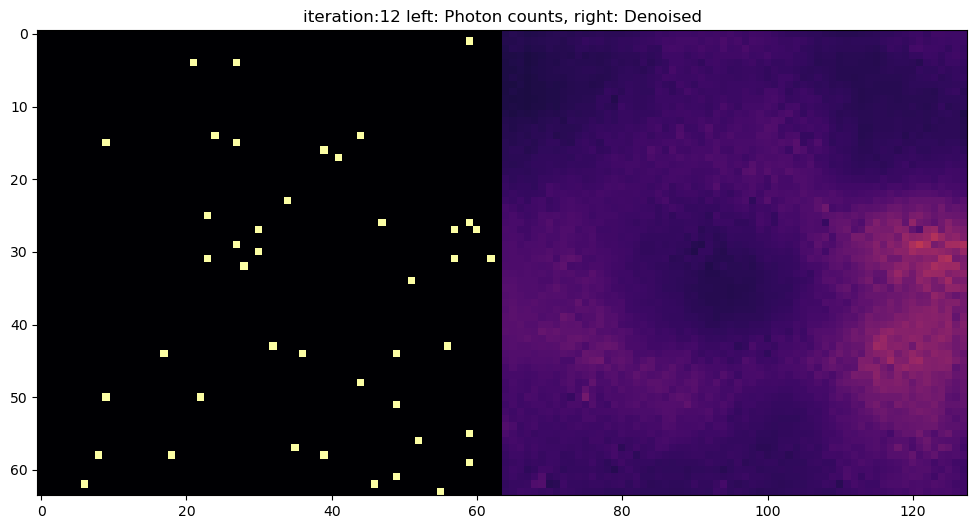

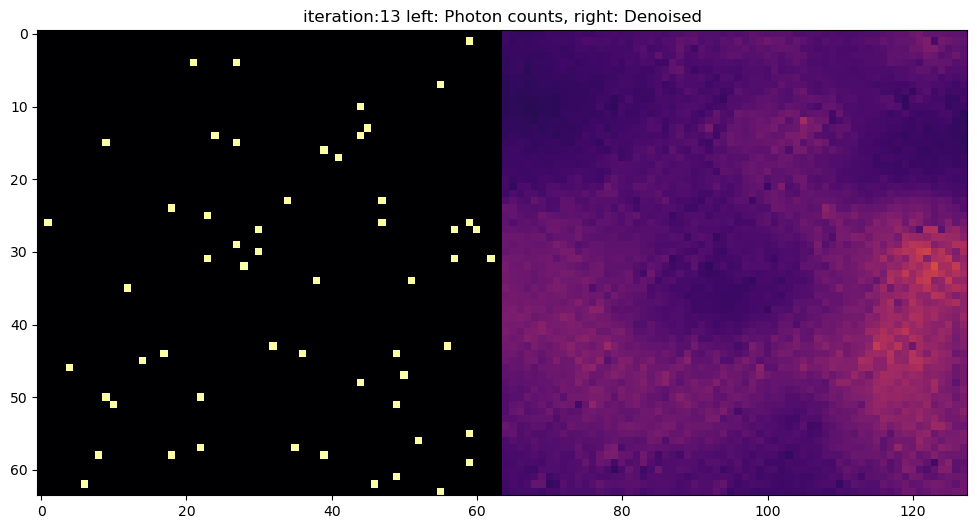

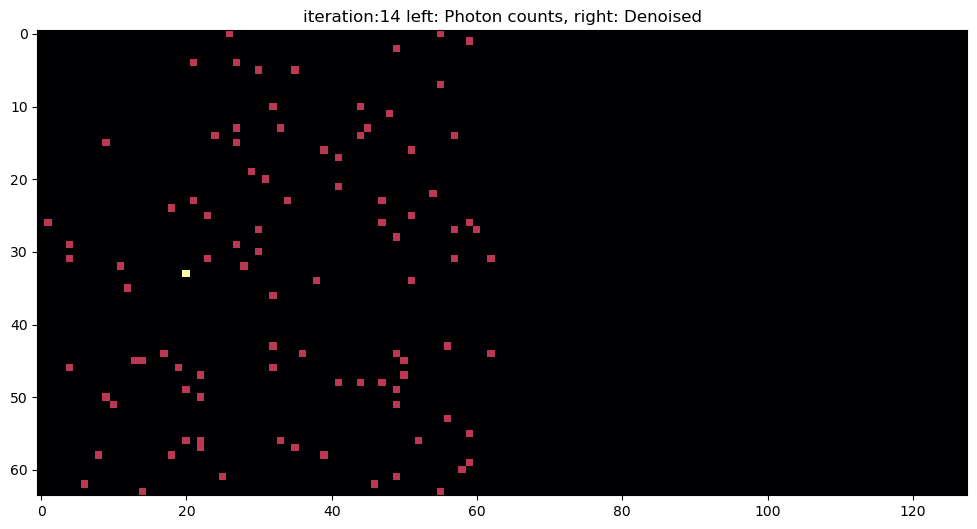

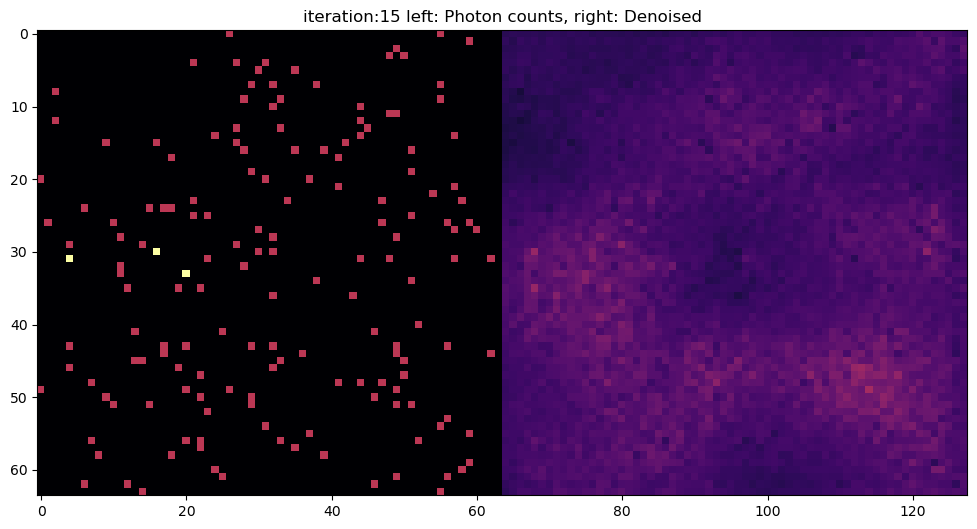

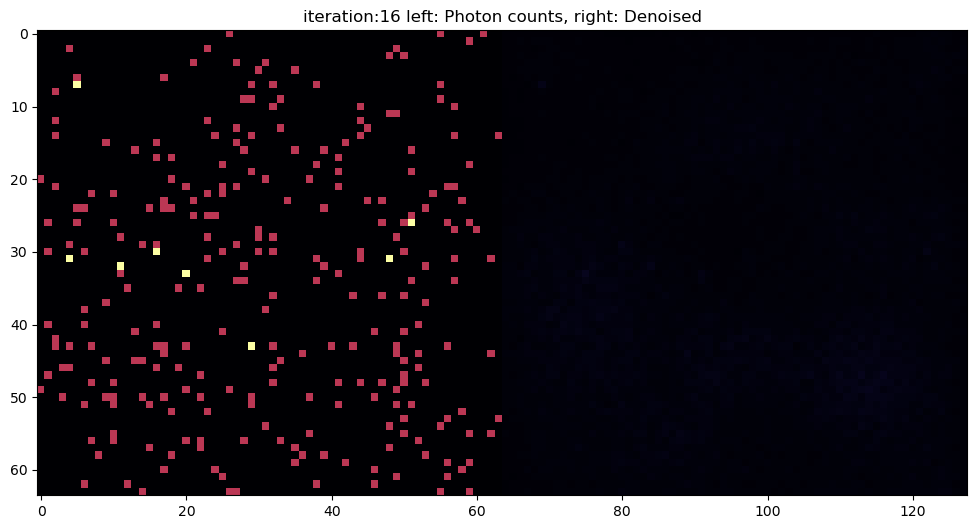

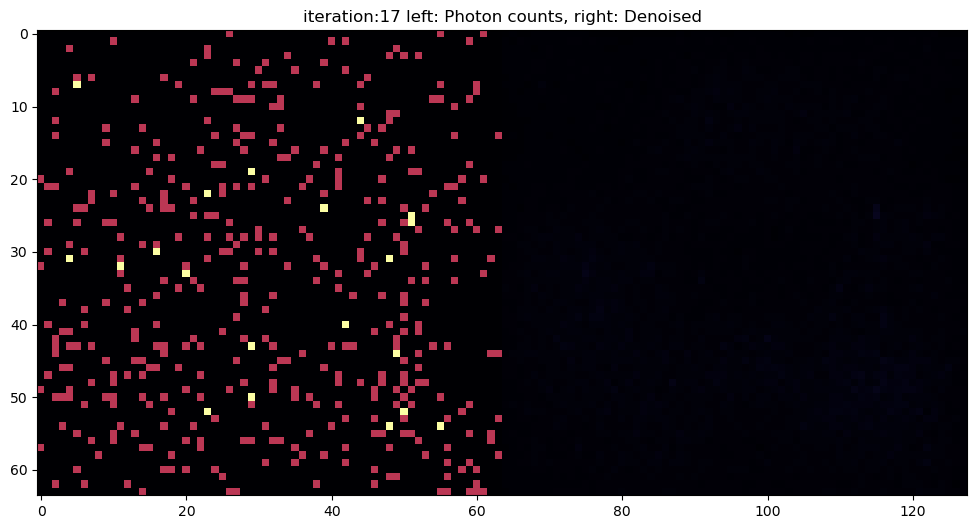

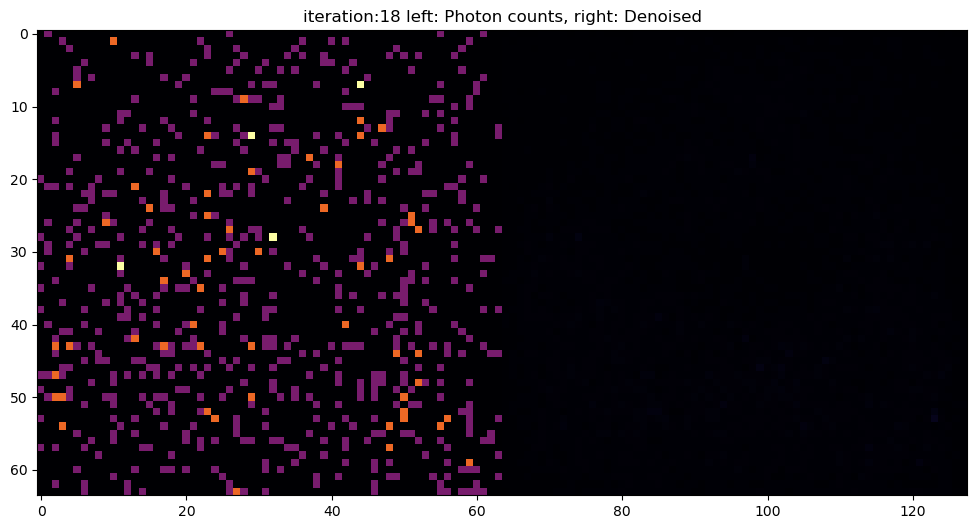

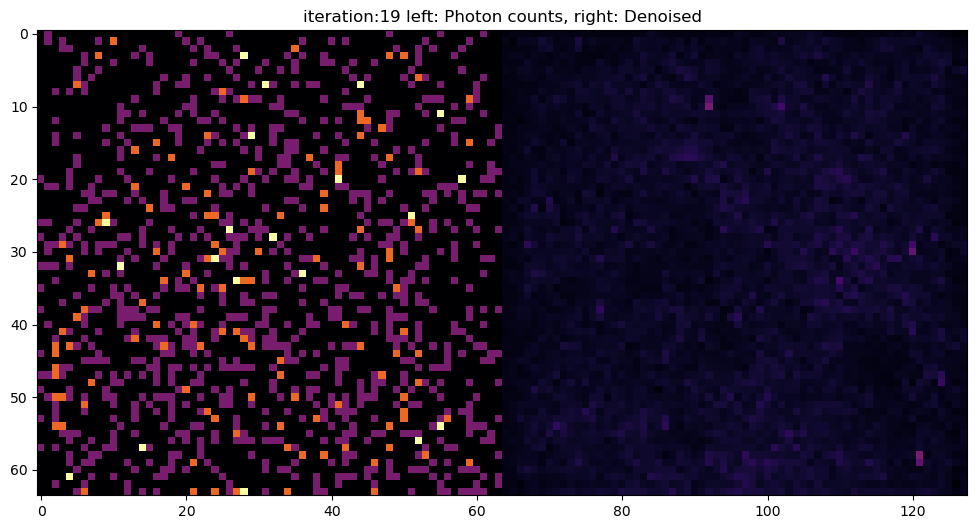

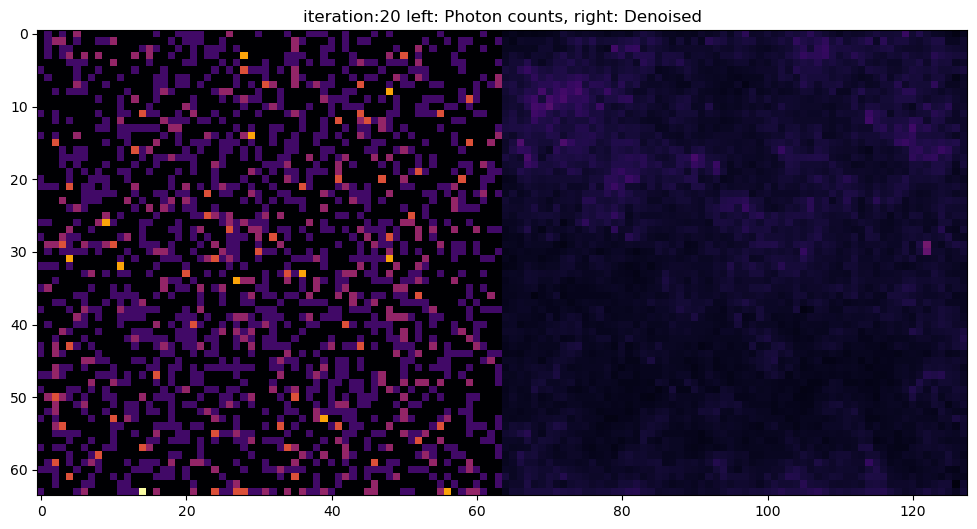

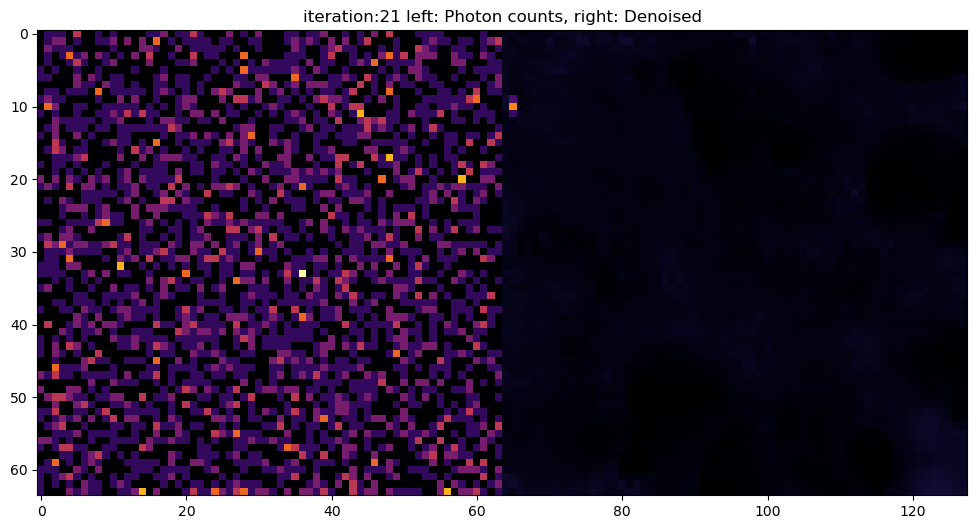

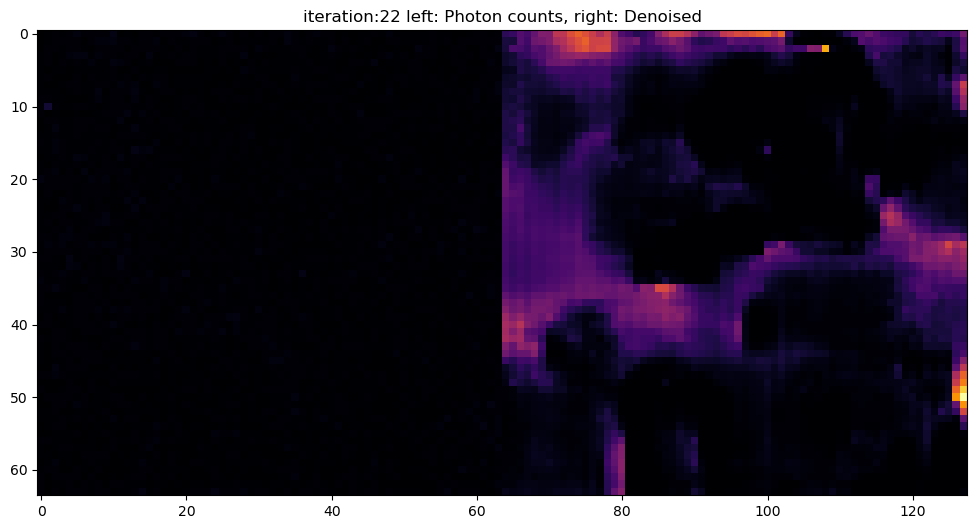

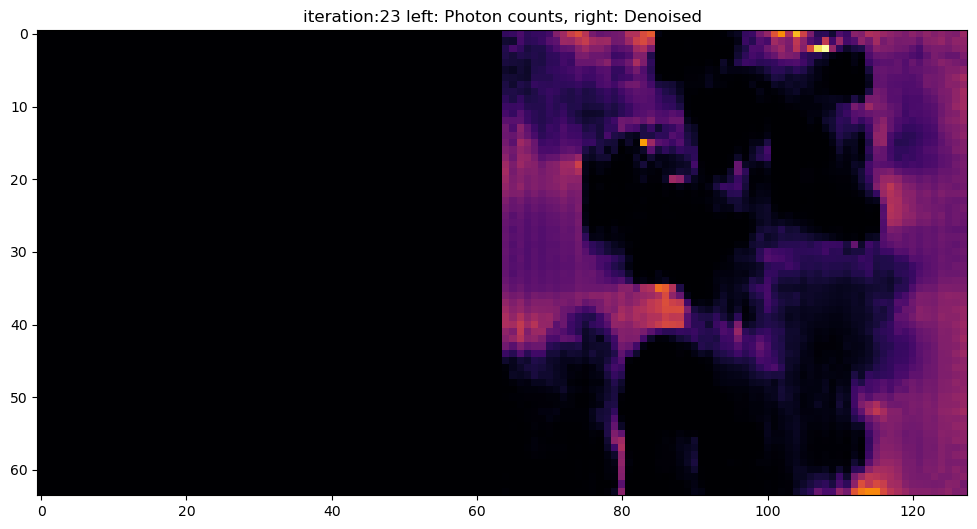

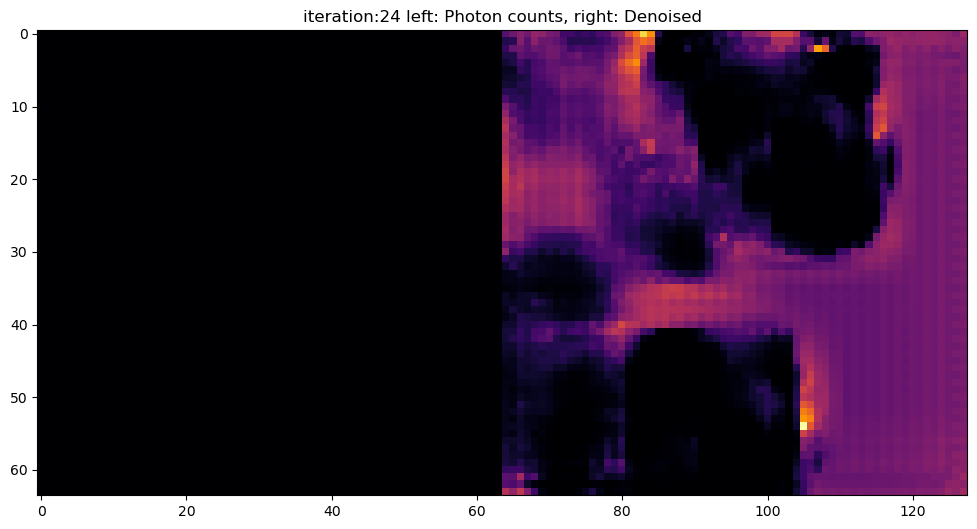

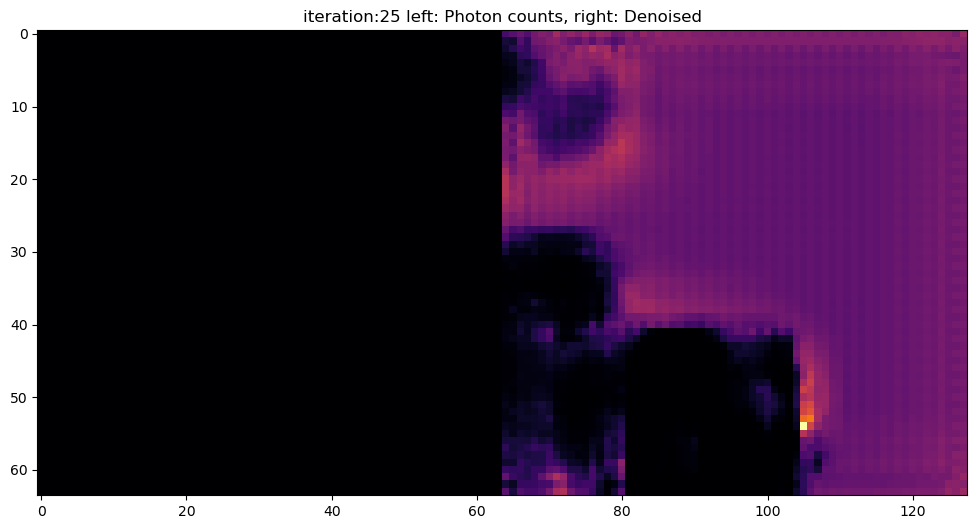

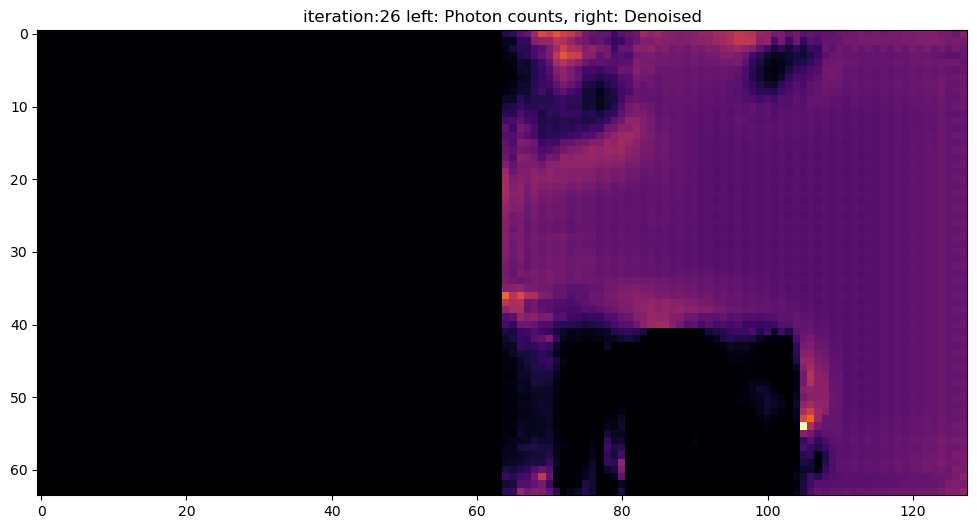

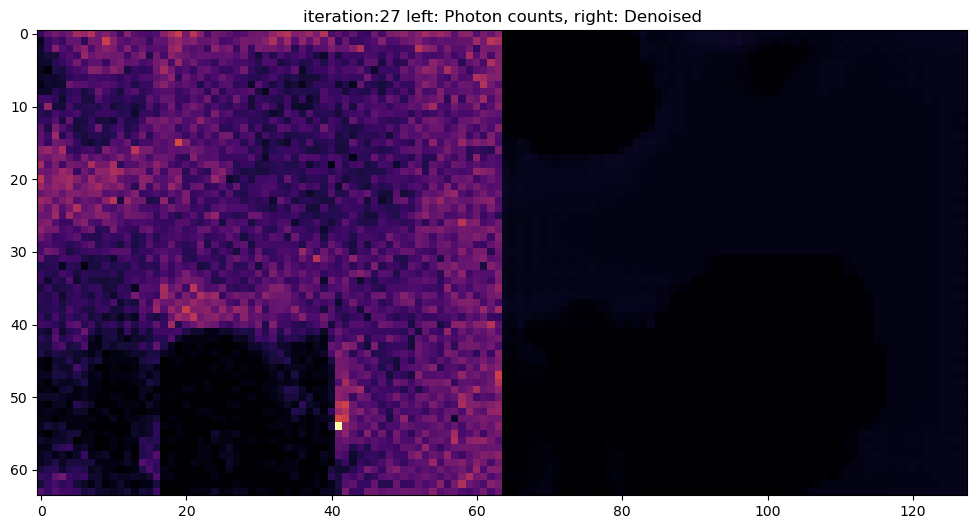

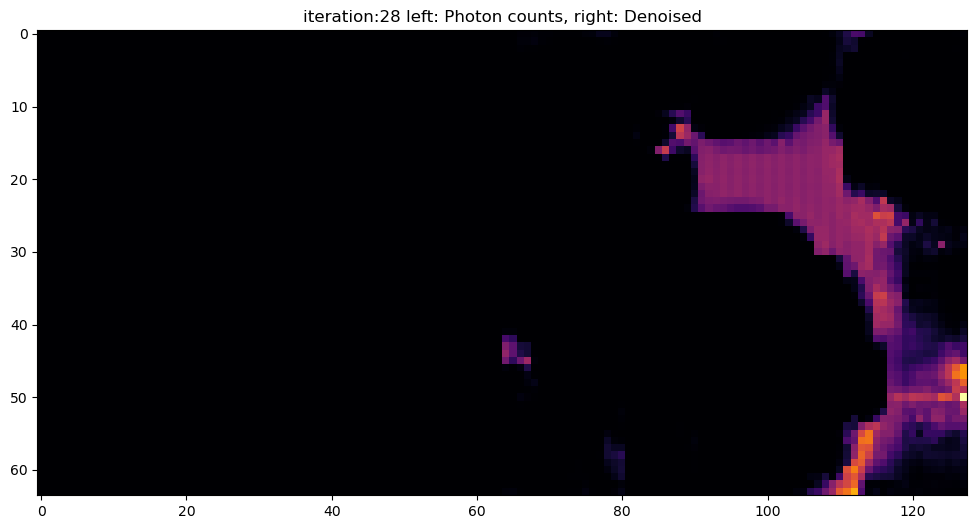

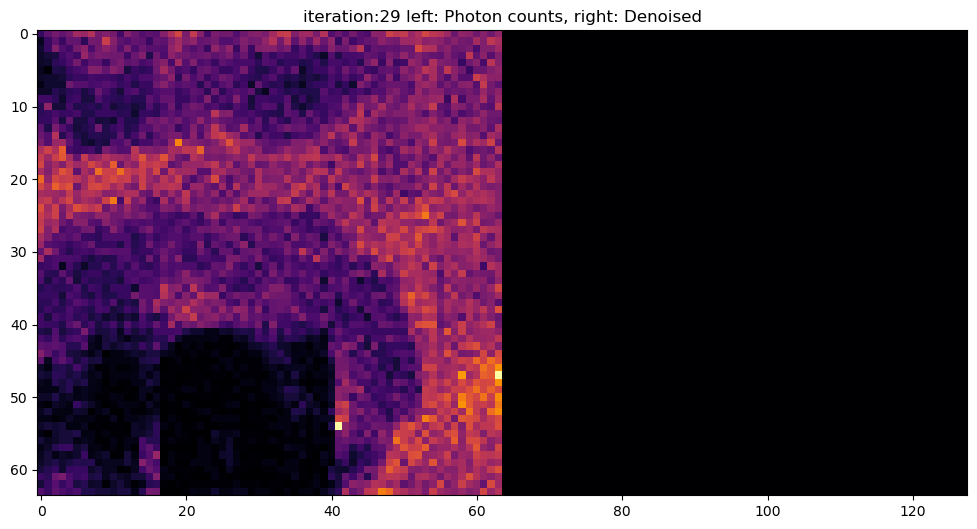

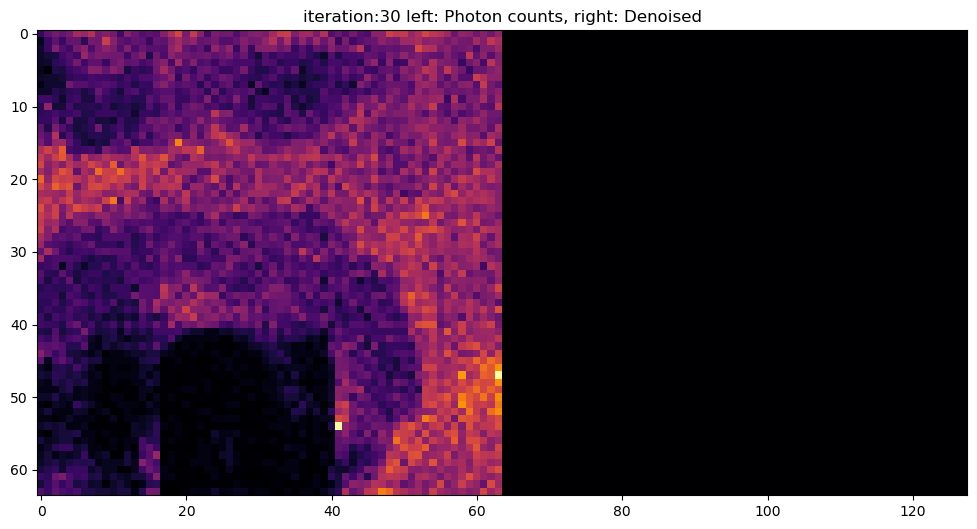

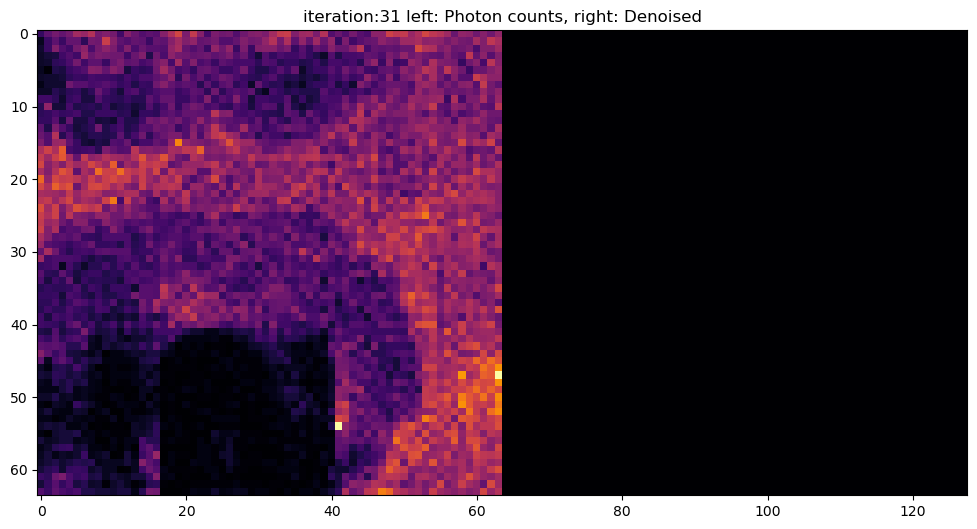

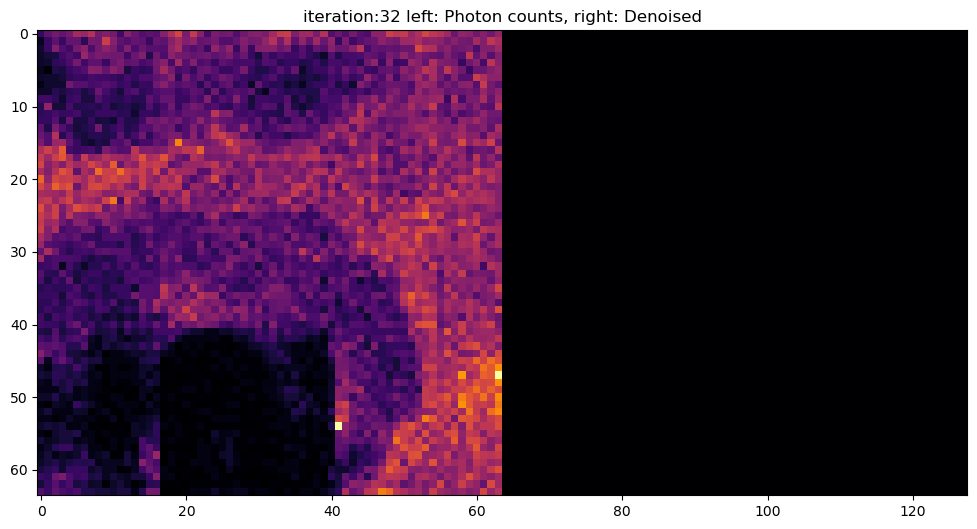

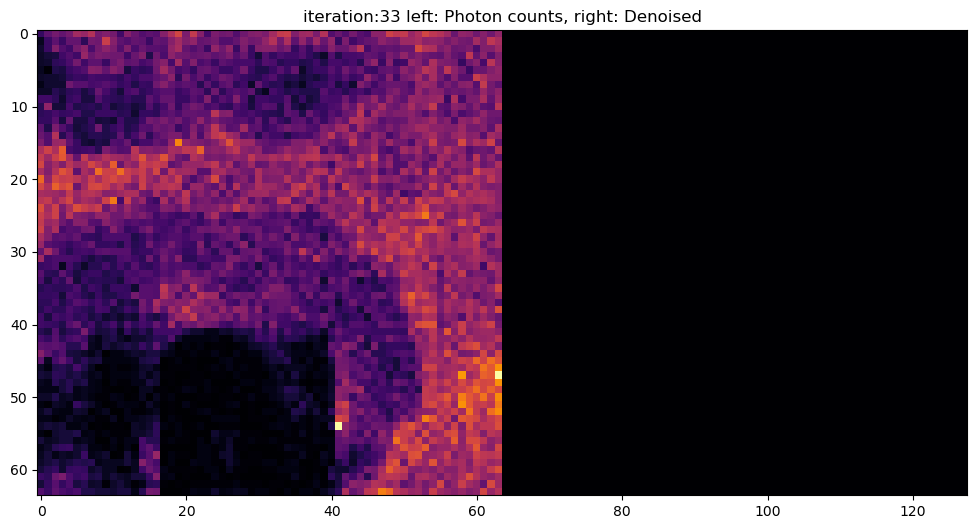

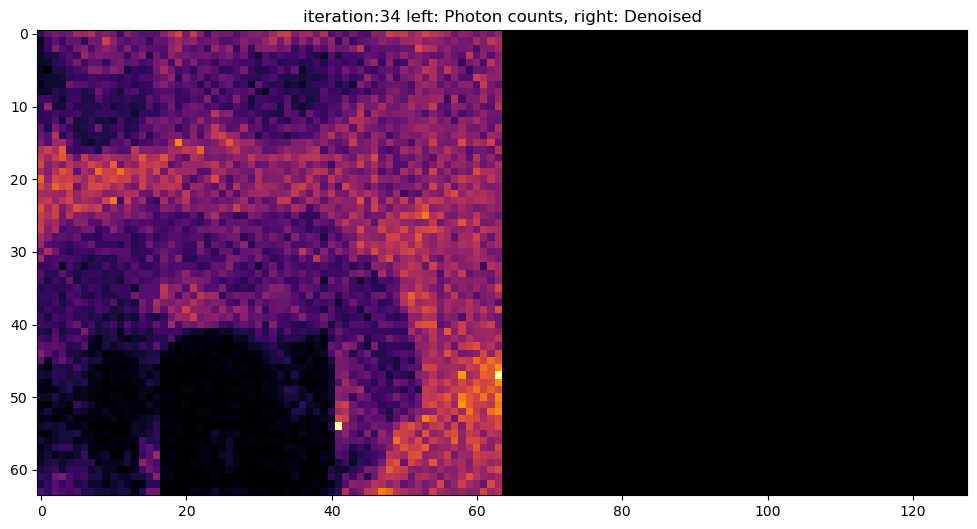

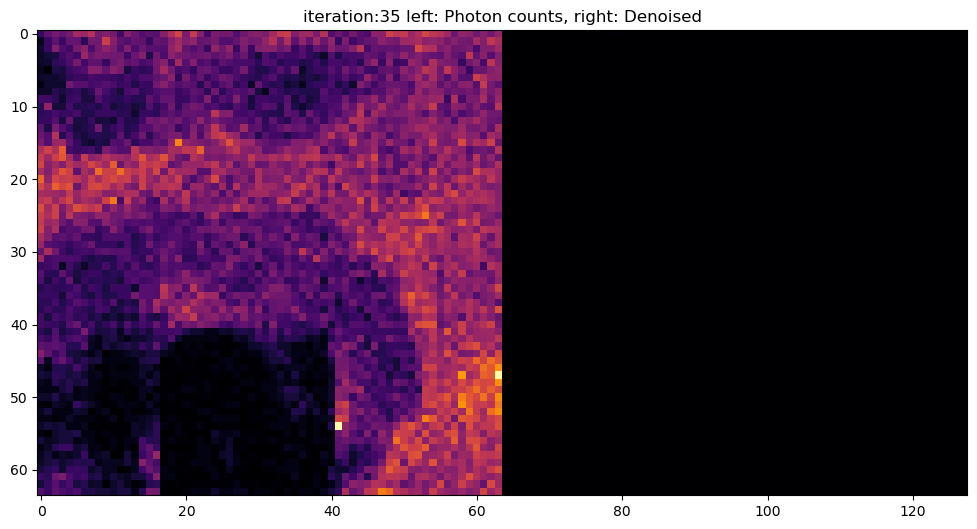

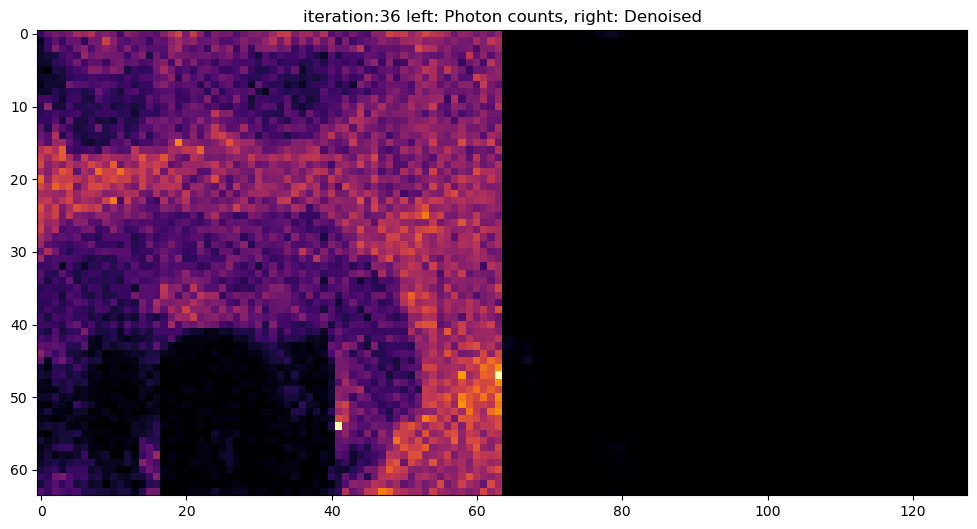

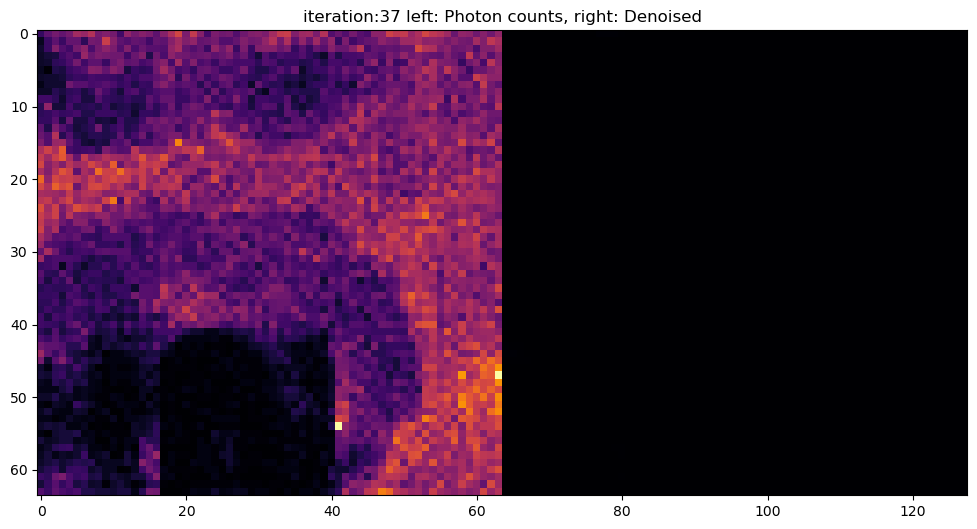

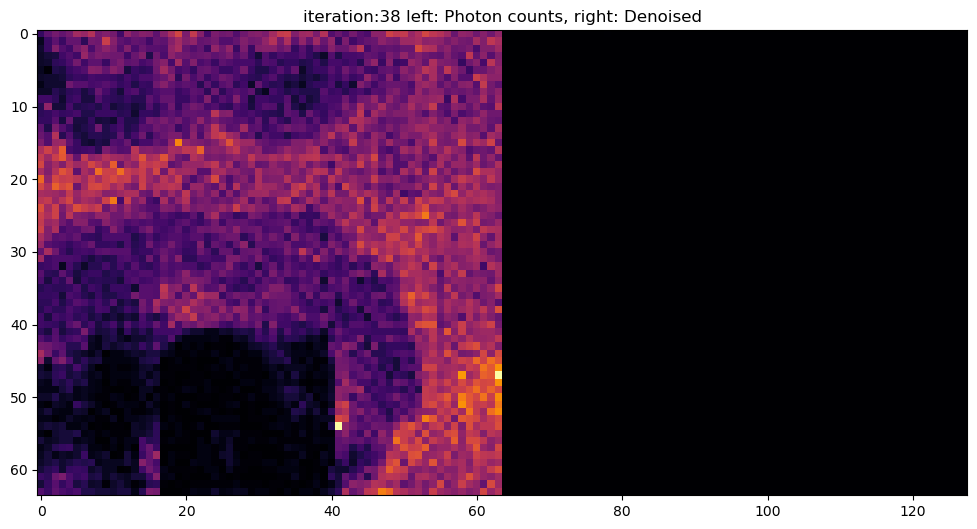

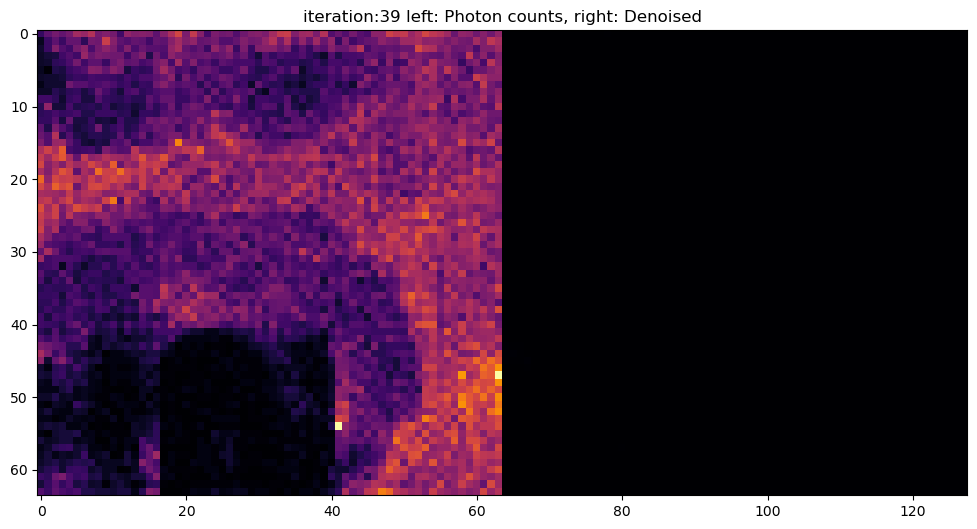

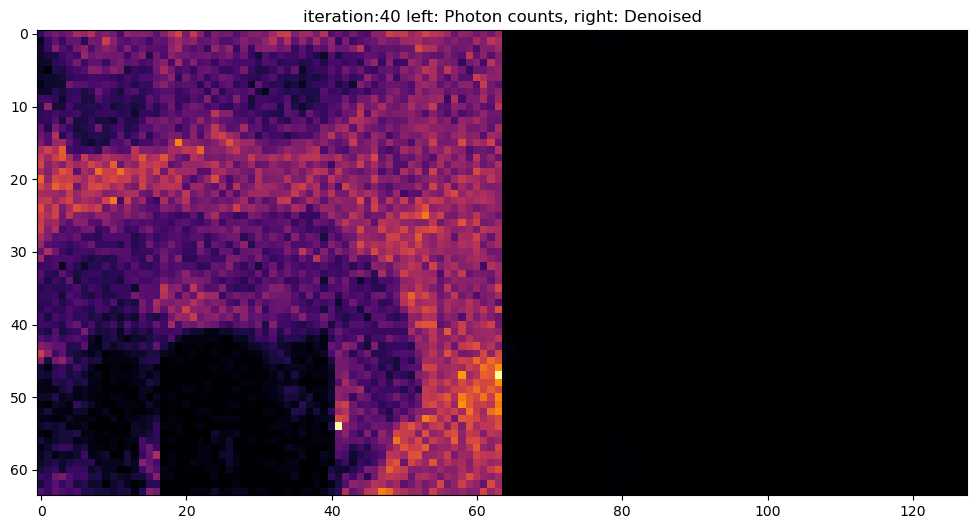

In [ ]:
print(stack[2][32, 99, 32])
for i in range(len(stack)):
    im = stack[i]
    # print(i)
    plt.figure(figsize=(12, 12))
    plt.imshow(im[20].transpose(), cmap="inferno")
    plt.title(f"iteration:{i} left: Photon counts, right: Denoised")
    plt.show()

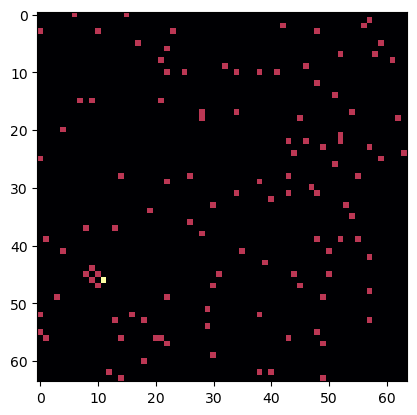

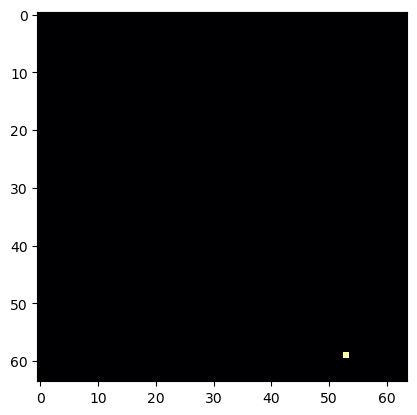

In [ ]:
data2 = dataset[1].detach().numpy()
plt.imshow(data2[0][32], cmap="inferno")
plt.show()
plt.imshow(data2[1][32], cmap="inferno")
plt.show()

